### Demonstration of Tiny-Analysis

In Straxen (XENONnt) there is *Mini-analysis*.
We don't have this here yet, but it's a super handy tool to have a few *quick glances* at your run in usualy just *one line of code* before (or also during) the actual analysis. These might be sanity checks or tasks/plots that you need a lot.

In the style of Mini-analysis I created *tiny-analysis*. It's a simple version, although on the same principles. So any function we write for tiny-analysis can later *easily be adopted* to mini-analysis once we update to a later version of strax.

Function contributions are well appreciated. I'll gladly explain how it works either here (see bottom) or in person - just hit me up.
Best practice is to write *versatile code* (similar tasks can also be done by giving some arguments, or e.g. don't assume n_pmts=8 bc that's not the case for e.g. the hermetic tpc) and *good documentation* (doc strings).

The idea is that you give the tiny-/mini-analysis *just a context and the run-id* and only optionally more arguments and that's it. Like this you can also easily cross-check with other runs or use data-kinds (i.e. peaks, events,..) that are currently not loaded.

If there's no intervention I'll gladly put this into straxbra (as is the case for straxen and Mini-analysis) for easier usage.


Let's have a quick look:

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import straxbra
import peaks_tiny as pt
import events_tiny as et


In [2]:
xc = straxbra.XebraContext()
run_ids = ['00250', '00177']  # krypton, cesium

/software/anaconda3/envs/strax/lib/python3.7/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


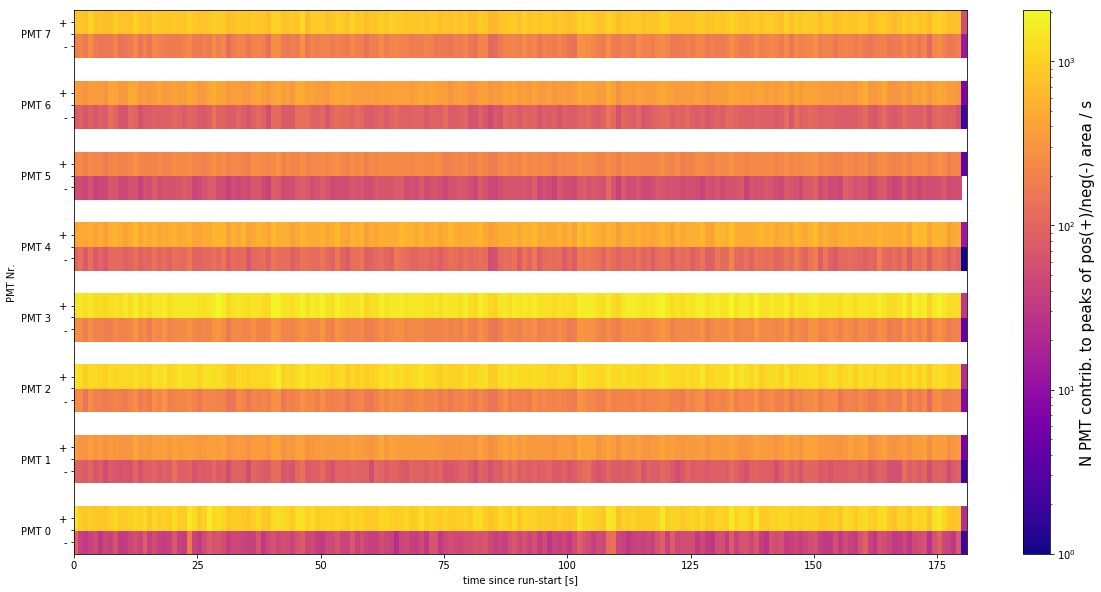

In [3]:
pt.pmt_activity(xc, run_ids[0])

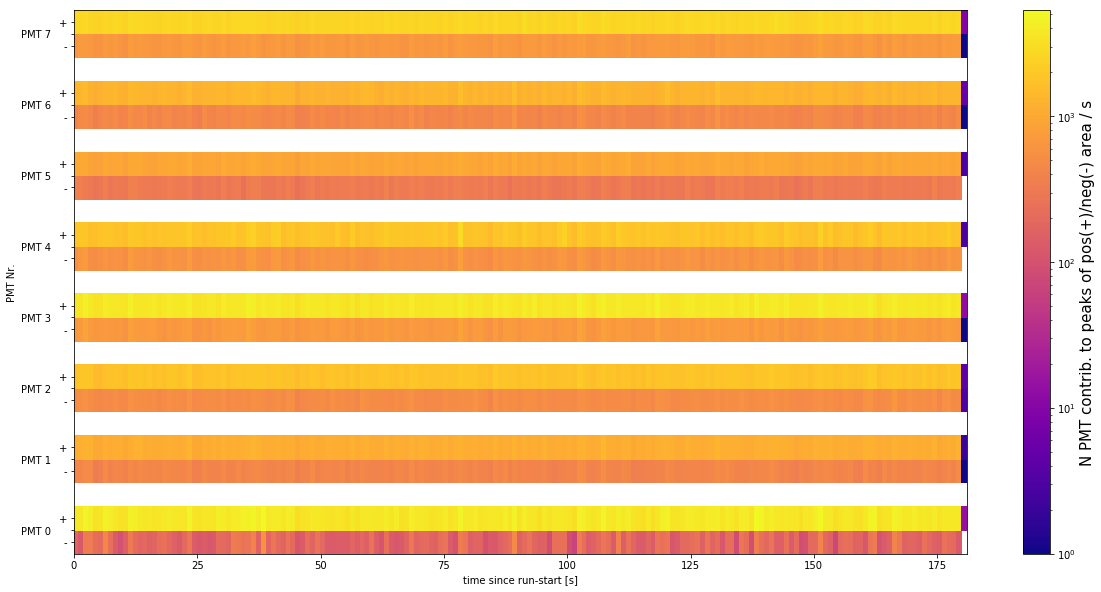

In [4]:
pt.pmt_activity(xc, run_ids[1])

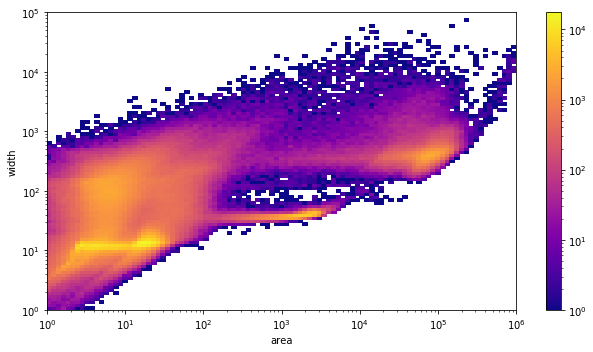

In [5]:
pt.peak2dhist(xc, run_ids[1])

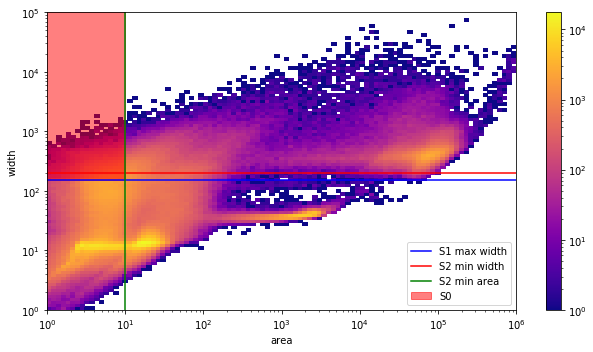

In [6]:
pt.peak2dhist(xc, run_ids[1])
plt.axhline(150, c='b', label='S1 max width')
plt.axhline(200, c='r', label='S2 min width')
plt.axvline(10, c='g', label='S2 min area')

plt.fill_between(
    [1, 10],
    [150, 150],
    [1e5, 1e5],
    alpha=0.5,
    color='red',
    label='S0')


plt.legend(loc='lower right');

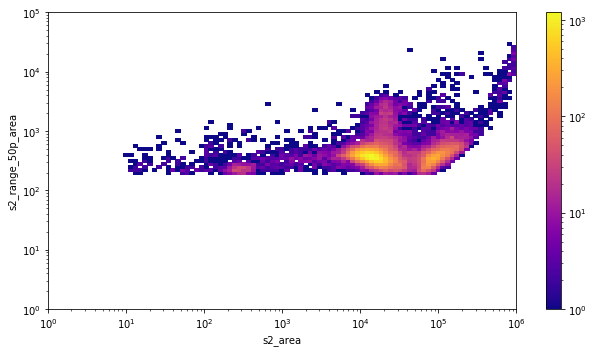

In [7]:
et.area_width(xc, run_ids[0])

In [9]:
et.area_width??

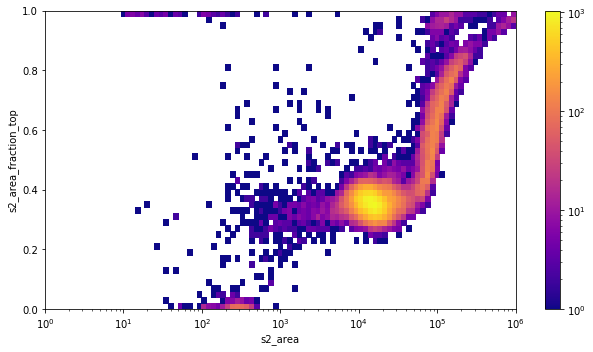

In [10]:
et.area_width(xc, run_ids[0], y='s2_area_fraction_top', ybins=np.linspace(0, 1, 51), ylog=False)

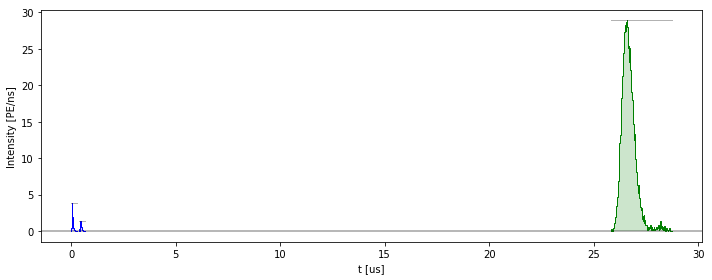

In [11]:
pt.plot_peaks(xc, run_ids[0], peak_idx=list(range(2,5)))

In [ ]:
pt.plot_peaks??

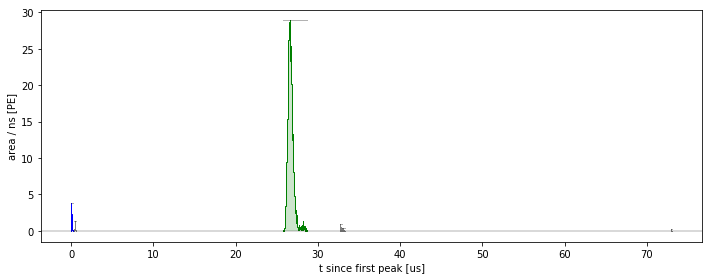

In [12]:
et.event_waveform(xc, run_ids[0])

In [14]:
et.event_waveform??

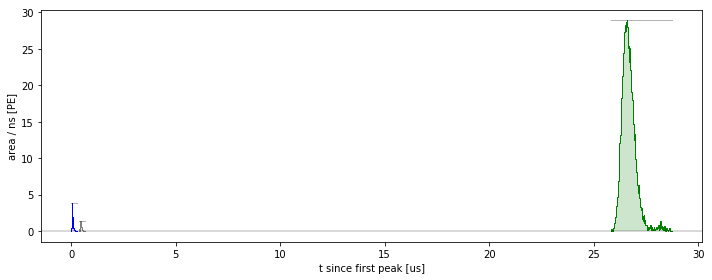

In [13]:
et.event_waveform(xc, run_ids[0], max_time=3e4)

### Implementation of one sample tiny-analysis function:

In [ ]:
@ta.tiny_analysis(requires=('events', 'event_basics',
                            'peaks'))
def event_waveform(events,
                   peaks,
                   event_nr=0,
                   xlabel='t since first peak [us]',
                   ylabel='area / ns [PE]',
                   title='',
                   peak_color='gray',
                   s1_color='b',
                   s2_color='g',
                   max_time=None,
                   is_log=False,
                   figsize=(10, 4),
                   **kwargs):
    """Plots peak waveforms of given event.

    Arguments for decorator:
    context -- straxbra context
    run_id  -- 5-digit zero padded run-id (str)


    Arguments:
    events  -- Provided by decorator (DataFrame)
    peaks   -- Provided by decorator (ndarray)

    Keyword arguments:
    event_nr   -- Index of event to plot (default 0, int)
    xlabel     -- Label of x-axis (str)
    ylabel     -- Label of y-axis (str)
    title      -- Title of Plot   (str)
    peak_color -- Plot color of peaks (default 'gray')
    s1_color   -- Plot color of main S1 (default 'b')
    s2_color   -- Plot color of main S2 (default 'g')
    max_time   -- Time in ns relative to first peaks start time
                  after which peaks are not plotted (int)
    is_log     -- Whether or not to plot y-axis logarithmicly (default False)
    figsize    -- mpl figsize (tuple)
    kwargs     -- Any kwargs plt.plot accepts, except color.
    """

    if 'color' in kwargs or 'c' in kwargs:
        raise ValueError('Give plot color via peak_color, s1_color and s2_color not color or c.')

    event = events.iloc[event_nr]
    peaks = peaks[(peaks['time'] >= event['time']) & (peaks['time'] < event['endtime'])]

    if max_time is not None:
        peaks = peaks[peaks['time'] <= peaks[0]['time'] + max_time]

    colors = {event['s1_index']: s1_color,
              event['s2_index']: s2_color}

    plt.figure(figsize=figsize)
    for idx, peak in enumerate(peaks):
        color = peak_color if idx not in colors else colors[idx]
        at.plot_peak(peak, t0=peaks[0]['time'], color=color, **kwargs)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()

    if is_log:
        plt.ylim(0.1, None)
        plt.yscale('log')
    else:
        plt.axhline(0, c='k', alpha=0.2)
